#  SpaceNet U-Net (adapted)

The original notebook was written by Alexey Bogatyrev named 'SpaceNetUnet'. \
Notebook: https://github.com/boggis30/SpaceNetUnet \
Associated blog post: https://medium.com/analytics-vidhya/u-net-engineering-5a84ee193aaf


This code is adapted from Alexey Bogatyrevs SpaceNetUnet. \
A deep neural network architecture (U-Net) is constructed for building detection from very-high resolution satellite imagery. \
The model is trained by SpaceNet Data of the dataset AOI Las Vegas. 

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorboard
import glob
import os
import re
import datetime
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from hyperopt import hp
from hyperopt import fmin, pyll, tpe, hp, STATUS_OK, Trials
import pickle
import time
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D

# Data Generators

generate a dataframe from the training data; containing all image tiles and the corresponding building masks \
requirement: all satellite image and building mask tiles are within the same folder

In [ ]:
# Define global variables
DIRECTORY = 'E:/W_Katrin/AOI_2_Vegas/AOI_2_Vegas_Train/tiles'

In [2]:
# gather all files 
files = glob.glob(os.path.join(DIRECTORY,'*'))

# create a list of all images in the directory
pattern_img = '.*\.jpg'
files_img = list(filter(re.compile(pattern_img).match,files))

# create a list of all labeled images / building masks
pattern_mask = '.*\.tif'
files_mask = list(filter(re.compile(pattern_mask).match,files))

files_mask = sorted(files_mask)
files_img = sorted(files_img)

print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)),
      'Mask files: {}'.format(len(files_mask)))

 All files: 7704
 Image files: 3852
 Mask files: 3852


In [3]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

# return a random sample [frac defines how big of a fraction of the original data the sampled data should be; 1 means equal]
df_files = df_files.sample(frac=1,random_state=10)

train_bound = int(len(df_files) * 0.7)
val_bound = int(len(df_files) * 0.85)

# define 70% of the data as trainings data and 15% for validation and 15% for testing
df_train = df_files.iloc[:train_bound]
df_val = df_files.iloc[train_bound:val_bound]
df_test = df_files.iloc[val_bound:]

print(' Train examples: {}\n'.format(len(df_train)),
      'Validation examples: {}\n'.format(len(df_val)),
      'Test examples: {}\n'.format(len(df_test)))

 Train examples: 2696
 Validation examples: 578
 Test examples: 578




Image and respective mask examples

Found 1 validated image filenames.
Found 1 validated image filenames.
196608


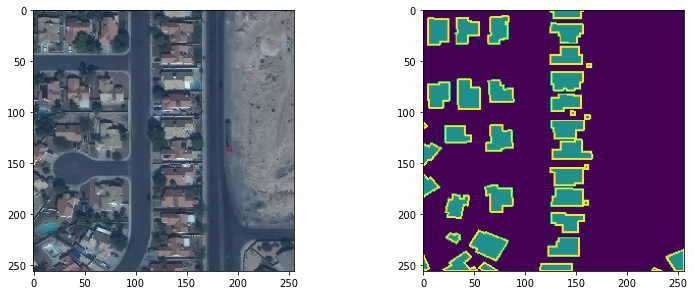

196608


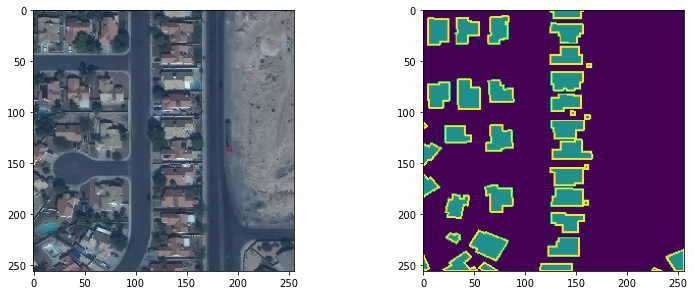

In [45]:
def make_tuple_gen(df_files,target_size,batch_size,seed):
    ''' 
    Generators are created for img and mask, to iterate over the dataframe containing paths to satellite imagery and building mask tiles.
    Real-time data augmentation can be included.
    
        Parameters: 
            df_files: Pandas dataframe, with columns 'img' and 'mask', containing file paths 
            target_size: A tuple containing two int numbers, describing desired spatial dimension of training data 
            batch_size: Int number 
            seed: Int number
        
        Returns: 
        Two generators (zipped), one for the satellite imagery and for the building masks
    '''
    # IMAGE GENERATOR
    img_gen = keras.preprocessing.image.ImageDataGenerator() # here: parameters for real-time data augmentation can be defined  
    
    # read data from dataframe  
    img_generator = img_gen.flow_from_dataframe(
        dataframe=df_files,        
        x_col='img',
        target_size=target_size,
        batch_size=batch_size,
        seed = seed,
        class_mode=None,
        color_mode='rgb')
  
    # MASK GENERATOR
    mask_gen = keras.preprocessing.image.ImageDataGenerator()

    mask_generator = mask_gen.flow_from_dataframe(
        dataframe=df_files,        
        x_col='mask',
        target_size=target_size,
        batch_size=batch_size,
        seed = seed,
        class_mode=None,
        color_mode='grayscale')
    
    return zip(img_generator, mask_generator)


def make_gen4unet(df_files,target_size = (256, 256),batch_size = 1, seed = 10):
    ''' 
    This function defines some parameters for function make_tuple_gen().
    Image and Mask tiles are resized to desired target size.
    Also: The values of the mask tiles are rescaled.
    
        Parameters: 
            df_files: Pandas dataframe, with columns 'img' and 'mask', containing file paths 
            target_size: A tuple containing two int numbers, describing desired spatial dimension of training data 
            batch_size: Int number 
            seed: Int number
        
        Returns: 
        Two generators, image_generator and modified mask_generator
    '''
    
    tuple_gen =  make_tuple_gen(df_files,target_size,batch_size,seed) 

    def _gen():
        while True:
            x,y = next(tuple_gen)
            y[y==100] = 1
            y[y==255] = 2
            yield x,y
    
    return _gen()

print('\nImage and respective mask examples\n')

# Show examples of training data 
genUnet = make_gen4unet(df_files.head(1))
for i in range(2):   
    xx,yy = next(genUnet)
    print(xx[0].size)
    xx = xx[0].astype(int)
    yy = np.squeeze(yy[0].astype(int)) #reduce by one axis

    plt.figure(figsize=1*np.array([2*6.4, 4.8]))
    plt.subplot(121)
    plt.imshow(xx)
    plt.subplot(122)
    plt.imshow(yy)
    plt.show()


###  Create training, validation and test generators here
here the batch size can be defined

In [46]:
train_gen = make_gen4unet(df_train, batch_size=1)
val_gen   = make_gen4unet(df_val, batch_size=1)
test_gen  = make_gen4unet(df_test,batch_size=578)

Found 2695 validated image filenames.
Found 2695 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.


# Building Model Architecture
in the following section the U-Net model is constructed

![title](SpaceNetUnet_Architecture.png)

In [5]:
def reduce_layer(n_classes):
    '''
    This function builds a layer for the final part of the U-Net, to reduce the amount of feature channels in two steps (orginally one step), 
    to mainain more information for building segmentation map. 
  
    Quote Alexey Bogatyrev: "The idea of this layer is the following: Original Unet has final conv layer with three filters. 
    Each filter has to be able to distinguish target class on the final feature map. Each filter has capacity of only 65 parameters, which might be insufficient.
    Improved Unet has increased number of filters per class in final conv layer. There are three groups of filters as per each class. Filters corresponding to 
    one classes are summed in the final layer before activation."
    
        Parameters: 
            n_classes: number of desired classes in the final semantic segmentation map
        
        Returns: 
            Feature Map with three Feature Channels  
  '''
  
  def _reduce_layer(x):

    n_channel = x.shape[-1] #take the number in last dimension/axis, corresponds with number of channels
        
    # n_channel must be divisible by n_classes
    assert n_channel % n_classes == 0 # % gives remainder of division, so if you divide n_channel by n_classes it should be 0
    # assert here means: check this condition and immediately trigger an error if the condition is false

    ch1 = int(n_channel/n_classes)
    ch2 = int(2*n_channel/n_classes)
    
    x1 = x[...,:ch1] #last dimension = n_channels/n_classes
    x2 = x[...,ch1:ch2] # last dimension ch1-ch2
    x3 = x[...,ch2:n_channel] 

    x1 = K.sum(x1,axis=-1) # sum of the values in a tensor, alongside the specified axis (axis = dimension)
    x2 = K.sum(x2,axis=-1) # here axis is e.g. (x,x,X), always the last one
    x3 = K.sum(x3,axis=-1)

    y = K.stack([x1,x2,x3],axis=-1) #Stacks a list of rank R tensors into a rank R+1 tensor

    return y

  return _reduce_layer


def conv_block(n_filter,batch_norm=True):
    '''
    This function summarizes the convolutions with their associated functions. 
    Carries out a 3x3 Convolution, then a Batch Normalization and a Rectified Linear Unit activation function (ReLU).
    
        Parameters: 
            n_filter: amount of filters used during convolution, also: desired amount of feature channels after convolution 
            batch_norm: if True, a Batch Normalization will be performed after the convolution and before the ReLU
        
        Returns: 
            batch of functions
    '''
    def _conv_block(x):
        
        if batch_norm:
            x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x) 
            x = keras.layers.BatchNormalization()(x) 
            x = keras.layers.ReLU()(x)
            else:  
  
            x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x)    
            x = keras.layers.ReLU()(x)
        return x
    return _conv_block


def unetConv2(n_filter,double_conv=True,batch_norm=True): #decide if you want to do either singular or double conv
    '''
    As one Encoder-block in the U-net consists of two consecutive convolutions, this function summarizes these double convolutions here. 
    
        Parameters: 
            n_filter: amount of filters used during convolution, also: desired amount of feature channels after convolution 
            double_conv: if True, two conv_blocks will be executed
            batch_norm: if True, a Batch Normalization will be performed after the convolution and before the ReLU
        
        Returns: Double or single convolution blocks 
    '''
  
    def _unetConv2(x):
        if double_conv:    
            x = conv_block(n_filter,batch_norm) (x)
            x = conv_block(n_filter,batch_norm) (x) 
        else:
            x = conv_block(n_filter,batch_norm) (x)
        return x

    return _unetConv2


def unetUp(n_filter,deconv=True): 
    '''
    This function constructs a Decoder-block. 
    Layers will be upsampled by a transposed convolution function or a simple upsamling function.
    
        Parameters: 
            n_filter: amount of filters used during deconvolution
            deconv: if True, the layers will be upsampled by a transposed convolution
        
        Returns: 
            Deconvolution block
    '''
    def _unetUp(input1,input2):
        if deconv:
            input2 = keras.layers.Conv2DTranspose(n_filter,(2,2),(2,2))(input2)
        else:
            input2 = keras.layers.UpSampling2D(size=(2,2))(input2) # Simple upscaling of the image using nearest neighbour or bilinear upsampling. 

        x = keras.layers.Concatenate()([input1,input2])

        return x

    return _unetUp


def unetModel(n_classes = 3,image_shape = (256,256,3) ,feature_scale=1, deconv=True,
              double_conv=True, batch_norm=True, 
              final_reduce=True,final_reduce_n_channel=30):
    '''
    This function builds the U-Net model by incorporating the former build functions. 
    
        Parameters: 
            n_classes: number of classes for the desired segmentation map 
            image_shape: desired output shape
            feature_scale: 
            deconv: if True, a transposed convolution will be used for Upsampling
            double_conv: if True, two consecutive conv_blocks will be executed
            batch_norm: if True, within a conv_block, a Batch Normalization will be performed after the convolution and before the ReLU
            final_reduce: if True, reduce_layer is applied
            final_reduce_n_channel: final_reduce_n_channel must be devisible by n_classes
            
        Returns: 
            U-Net model
    '''
    filters = [32, 64, 128, 256, 512]
    filters = [x // feature_scale for x in filters]

    x = keras.layers.Input(image_shape)

    conv1 = unetConv2(filters[0],double_conv,batch_norm) (x)
    maxpool1 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv1)

    conv2 = unetConv2(filters[1],double_conv,batch_norm) (maxpool1)
    maxpool2 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv2)

    conv3 = unetConv2(filters[2],double_conv,batch_norm) (maxpool2)
    maxpool3 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv3)

    conv4 = unetConv2(filters[3],double_conv,batch_norm) (maxpool3)
    maxpool4 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv4)

    center = unetConv2(filters[4],double_conv,batch_norm) (maxpool4)

    up_concat4 = unetUp(filters[3],deconv) (conv4,center)
    up_concat3 = unetUp(filters[2],deconv) (conv3,up_concat4)
    up_concat2 = unetUp(filters[1],deconv) (conv2,up_concat3)
    up_concat1 = unetUp(filters[0],deconv) (conv1,up_concat2)
    
    if final_reduce:
        final = keras.layers.Conv2D(final_reduce_n_channel,(1,1)) (up_concat1) #first convolute to size 1,1
        final = keras.layers.Lambda(reduce_layer(n_classes)) (final) # call the function reduce_layer to be performed on the last layer

    else: # if we do not want to reduce the final layer, we only convolute
        final = keras.layers.Conv2D(n_classes,(1,1)) (up_concat1)
    
    final_softmax = keras.activations.softmax(final, axis=-1) # converts a vector of values to a probability distribution
    model  = keras.Model(x,final_softmax)  # instantiate (erzeugen) the model
    
    return model

##  Validation

In [48]:
def validate_image(img,mask,model):
    '''
    This functions helps to visually assess the accuracy of the trained model. 
     
        Parameters: 
            img: use make_gen4unet() to generate a img example
            mask: use make_gen4unet() to generate a mask example
            model: trained model
        Returns: 
            validation plot
            predicted mask 
            maximum rendered predicted mask
    '''
    
    mask_pred = model.predict(img)

    i=0
    img = img[i].astype(int)
    mask = np.squeeze(mask[i].astype(int))
    mask_pred = np.squeeze(mask_pred[i]) 
    mask_pred_rend = np.argmax(mask_pred,axis=-1) 

    plt.figure(figsize=0.8*np.array([4*6.4, 4.8]))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.imshow(mask)
    plt.subplot(143)
    plt.imshow(mask_pred)
    plt.subplot(144)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

def plot_history(history_dict):
    '''
    This functions visualizes loss and sparse categorical accuracy during the training process.
    Can also be visualized by using Tensorboard.
     
        Parameters: 
            history_dict: a history object. Its history_dict.history attribute is a reord of training loss values and metrics values at successive epochs, 
                          as well as validation loss values and validation metrics values.
        
        Returns: 
            two history plots
    '''
    metrics = ['loss', 'sparse_categorical_accuracy'] 
    val_metrics = ['val_los', 'val_sparse_categorical_accuracy']  
    
    epochs = range(1, len(history_dict['loss']) + 1)
    
    plt.figure(figsize=0.8*np.array([6*6.4, 4.8]))
    for i,metric in enumerate(metrics): 
        plt.subplot(141+i)    
        plt.plot(epochs, history_dict[metric], 'bo', label='Training ' + metric) 
        plt.plot(epochs, history_dict['val_' + metric], 'b', label='Validation' + metric) 
        plt.title('Training and validation ' + metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 47)

# Model Training

## Unet Training

In [8]:
# call model architecture
model = unetModel(final_reduce=True, final_reduce_n_channel=30) 

# configure the model for training
model.compile(optimizer='adam', metrics= ['sparse_categorical_accuracy'], loss= 'sparse_categorical_crossentropy')

In [ ]:
%%time
# adapt logdir folder every time running the model to save event files in right folder
logdir = 'log_dir/improved/0'
os.makedirs(logdir,exist_ok=True)


tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                         )

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                               min_delta=0.001,  
                                               patience=20,
                                               restore_best_weights=True
                                              )

                                    
# Train the model
history_model = model.fit(train_gen, 
                          steps_per_epoch=25, 
                          epochs=200,
                          verbose=1, 
                          validation_data=val_gen,
                          validation_steps=19,
                          callbacks=[early_stopping, tensorboard])

In [9]:
# Save / Load the model with weights

model.save("0_model")
#model = keras.models.load_model("0_model")
#model.summary()

## Unet Validation

In [ ]:
plot_history(history_model.history)

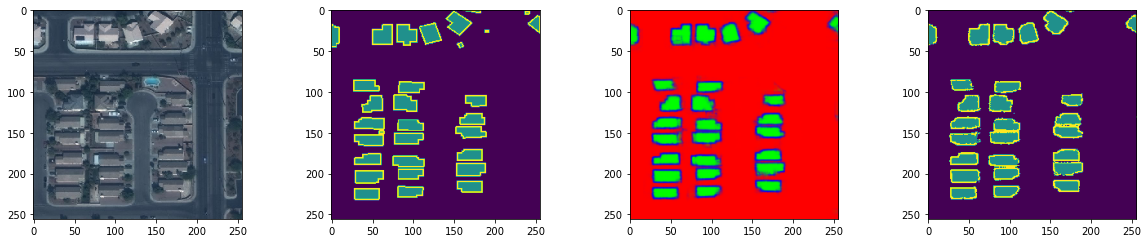

In [38]:
_ = validate_image(img_val,mask_val,model)
# 1: img  2: mask  3: mask_prediction improved_model  4: mask_pred_rend improved_model 

## Unet Analysis
by using Tensorboard

In [2]:
%load_ext tensorboard
%tensorboard --logdir 'E:\W_Katrin\InnovationLab\log_dir\improved\'

Reusing TensorBoard on port 6006 (pid 4992), started 18 days, 4:39:45 ago. (Use '!kill 4992' to kill it.)